In [1]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/nlp project'

/content/drive/My Drive/nlp project


In [19]:
import pandas as pd
file_name = 'English.txt'
filee=open(file_name)
English_Content=[]
for line in filee:
  English_Content.append(line.replace('\n',''))

file_name='Urdu.txt'
filee=open(file_name)
Urdu_Content=[]
for line in filee:
  Urdu_Content.append(line.replace('\n',''))


text_pairs = []
for i in range(0,len(English_Content)):
    english, urdu = English_Content[i], Urdu_Content[i]
    english = "[start] " + english + " [end]"
    text_pairs.append((english,urdu))


In [20]:
import random
print(random.choice(text_pairs))

('[start] Oil prices dive on stronger dollar [end]', 'تیل کی قیمتیں مضبوط ڈالر پر ڈوبکی')


In [21]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

In [22]:
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


In [23]:
from tensorflow.keras import layers

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 30000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [24]:

train_english_texts = [pair[0] for pair in train_pairs]
train_urdu_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_urdu_texts)
target_vectorization.adapt(train_english_texts)


In [27]:
batch_size = 512

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "urdu": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((spa_texts, eng_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)     

In [28]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['urdu'].shape: {inputs['urdu'].shape}")
    print(f"targets.shape: {targets.shape}")



inputs['english'].shape: (512, 20)
inputs['urdu'].shape: (512, 20)
targets.shape: (512, 20)


### Transformers

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


In [30]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    def get_causal_attention_mask(self, inputs):
      input_shape = tf.shape(inputs)
      batch_size, sequence_length = input_shape[0], input_shape[1]
      i = tf.range(sequence_length)[:, tf.newaxis]
      j = tf.range(sequence_length)
      mask = tf.cast(i >= j, dtype="int32")
      mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
      mult = tf.concat(
          [tf.expand_dims(batch_size, -1),
            tf.constant([1, 1], dtype=tf.int32)], axis=0)
      return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [31]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [32]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="urdu")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [37]:
model = transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
137/137 [==============================] - 73s 536ms/step - loss: 3.6864 - accuracy: 0.2602 - val_loss: 3.4815 - val_accuracy: 0.2674
Epoch 2/30
137/137 [==============================] - 76s 555ms/step - loss: 3.4748 - accuracy: 0.2917 - val_loss: 3.3188 - val_accuracy: 0.3027
Epoch 3/30
137/137 [==============================] - 77s 566ms/step - loss: 3.2881 - accuracy: 0.3202 - val_loss: 3.1659 - val_accuracy: 0.3265
Epoch 4/30
137/137 [==============================] - 78s 572ms/step - loss: 3.1220 - accuracy: 0.3460 - val_loss: 3.0942 - val_accuracy: 0.3374
Epoch 5/30
137/137 [==============================] - 79s 575ms/step - loss: 2.9724 - accuracy: 0.3705 - val_loss: 3.0361 - val_accuracy: 0.3313
Epoch 6/30
137/137 [==============================] - 79s 574ms/step - loss: 2.8337 - accuracy: 0.3922 - val_loss: 2.9932 - val_accuracy: 0.3545
Epoch 7/30
137/137 [==============================] - 79s 575ms/step - loss: 2.7062 - accuracy: 0.4134 - val_loss: 2.9731 - val_ac

KeyboardInterrupt: ignored

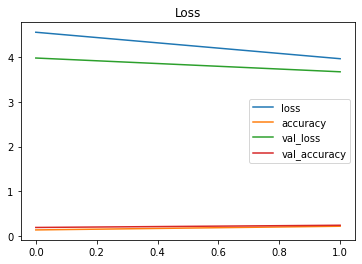

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
pd.DataFrame(model.history).plot()
plt.title("Loss")
plt.show()

In [41]:
transformer.save("model.h5")

In [ ]:
from tensorflow.keras.models import load_model
transformer = load_model('model.h5',custom_objects={'PositionalEmbedding':PositionalEmbedding,'TransformerEncoder':TransformerEncoder,'TransformerDecoder':TransformerDecoder})

In [39]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_urdu_texts = [pair[1] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_urdu_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))


-
ان کوششوں میں فائر فائٹرز کو قطرے پلانے کی مہمات شامل ہوں گی۔
[start] these efforts include explanation rate substantial [end]
-
پچھلی بار شمارے کا تعارف دیتے ہوئے کچھ بدمزگی سی ہوگئی تھی اگر آپ کو یاد ہو ۔
[start] last time [UNK] introduction that if you had a little [UNK] you remember [end]
-
دوستانہ گھر سَب سے اَچّھا گھر ۔
[start] a friendly house is the best of houses [end]
-
ووٹ پر 2005 کے امن معاہدے کے ایک حصے کے طور پر اتفاق رائے ہوا تھا جس نے شمال اور جنوب کے مابین 22 سالہ جنگ کو ختم کیا تھا۔
[start] it was agreed right for [UNK] as a 2005 of peace agreement said and 17 of the north of the
-
وہ سرمایہ کاری کی پیچیدہ پالیسیاں ہیں۔
[start] they are they policies complex [end]
-
یہ بہت مایوس کن تھا کہ فیصلہ کافی نہیں تھا ، خاص کر جب سے ہم نے اسکول کے لئے اپنی حمایت برقرار رکھی ہے۔
[start] it was very disappointing that it was not very disappointing when we did not get you particularly good for school
-
اضطراب یا بے قراری ظاہر کرنا ۔
[start] [UNK] ones nose at [end]
-
تجارت کے مع

In [43]:
from nltk.translate.bleu_score import corpus_bleu

def bleu_score(testdata):

    actual, predicted = [], []
    for i in range(100):
      pair = testdata[i]
      actual.append(pair[0])
      predicted.append(decode_sequence(pair[1]))
    

    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
   
    
    return bleu_dic

# Compute the BLEU Score
bleu_test = bleu_score(test_pairs)

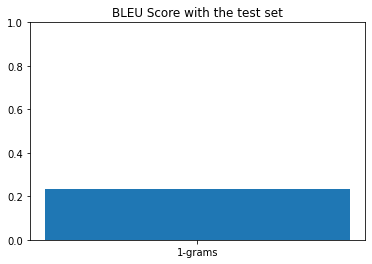

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()